pip install fpdf  
pip install kaleido  
pip install dataframe_image  
pip install pandas  
pip install matplotlib  

In [1]:
import fpdf
from fpdf import FPDF
import time
import pandas as pd
import dataframe_image as dfi
import os
import matplotlib.pyplot as plt

In [44]:
def create_letterhead(pdf, WIDTH):
    pdf.image("./pdf_img/ocl_log.png", 0, 0, WIDTH)
    
def create_title(title, pdf):
    
    # Add main title
    pdf.set_font('Helvetica', 'b', 35)  
    pdf.ln(40)
    pdf.write(5, title)
    pdf.ln(10)
    
    # Add date of report
    pdf.set_font('Helvetica', '', 14)
    pdf.set_text_color(r=128,g=128,b=128)
    today = time.strftime("%d/%m/%Y")
    pdf.write(4, f'{today}')
    
    # Add line break
    pdf.ln(10)
    
def write_to_pdf(pdf, words, font, r = 0, g = 0, b = 0):
    
    # Set text colour, font size, and font type
    pdf.set_text_color(r=r,g=g,b=b)
    pdf.set_font('Helvetica', '', font)
    
    pdf.write(5, words)

class PDF(FPDF):

    def footer(self):
        self.set_y(-15)
        self.set_font('Helvetica', 'I', 8)
        self.set_text_color(128)
        self.cell(0, 10, 'Audio Simon task', 0, 0, 'R')
        
def generate_matplotlib_piechart(df, filename):
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = ["Correct", "Incorrect"]
    sales_value = [len(df[df["ans"] == "corr"]), len(df) - len(df[df["ans"] == "corr"])]
    
    # Colors
    colors = ['#A8DADC', '#E63946']
    explode = [0, 0.30]
    
    # Create subplot
    fig, ax = plt.subplots()
    
    # Generate pie chart
    ax.pie(sales_value, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False, explode=explode, colors=colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Save the plot as a PNG
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    
    plt.show()

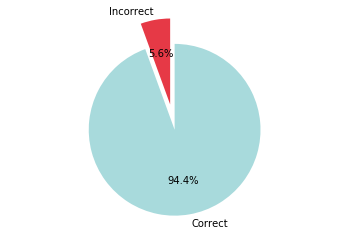

''

In [45]:
#최근 검사 csv 파일 load
folder_path = 'simon/data/' #파일 경로 상대 위치
each_file_path_and_gen_time = []
    
for each_file_name in os.listdir(folder_path):
    if 'csv' in each_file_name:
        each_file_path = folder_path + each_file_name
        each_file_gen_time = os.path.getctime(each_file_path) 
        each_file_path_and_gen_time.append((each_file_path, each_file_gen_time))

most_recent_file = max(each_file_path_and_gen_time, key=lambda x: x[1])[0]

#검사자 이름 추출
tester_name = most_recent_file.split('_')[0]
tester_name = tester_name.split('/')[2]

#최근 검사 csv 파일 load
folder_path = 'simon/data/' #파일 경로 상대 위치
each_file_path_and_gen_time = []
    
for each_file_name in os.listdir(folder_path):
    if 'csv' in each_file_name:
        each_file_path = folder_path + each_file_name
        each_file_gen_time = os.path.getctime(each_file_path) 
        each_file_path_and_gen_time.append((each_file_path, each_file_gen_time))

most_recent_file = max(each_file_path_and_gen_time, key=lambda x: x[1])[0]

#검사자 이름 추출
tester_name = most_recent_file.split('_')[0]
tester_name = tester_name.split('/')[2]

#검사 결과 df 전처리
df = pd.read_csv(most_recent_file)
df = df.iloc[3:39]

df = df[["Congruent", "alphabet", "corrAns", "key_resp_4.corr", "key_resp_4.rt"]]

df["ans"] = df["key_resp_4.corr"]
for i in range(len(df["key_resp_4.corr"])):
    if df["key_resp_4.corr"].iloc[i] == 0:
        df["ans"].iloc[i] = "wrong"
    else:
        df["ans"].iloc[i] = "corr"
        
df = df.reset_index()
df = df[["Congruent","alphabet", "corrAns", "key_resp_4.corr", "key_resp_4.rt", 'ans']]

df = df.rename(columns={'key_resp_4.corr':'corr'})
df = df.rename(columns={'key_resp_4.rt':'rt'})

#정답률 이미지 저장
generate_matplotlib_piechart(df, "cor_pie.png")

#검사결과 pdf 파일로 출력
TITLE = tester_name +"'s AST Report"
WIDTH = 209.5
HEIGHT = 297

# Create PDF
pdf = PDF()

pdf.add_page()

create_letterhead(pdf, WIDTH)
pdf.ln(1)
create_title(TITLE, pdf)

pdf.image("pdf_img/cor_percent.png", w=180)
pdf.ln(5)
write_to_pdf(pdf, "    Your correct point : " , 15)
write_to_pdf(pdf, str(len(df[df["ans"] == "corr"])) , 15, 255)
write_to_pdf(pdf, "/" + str(len(df)) , 15)
pdf.ln(7)
write_to_pdf(pdf, "    Sound and Light Same Case : ", 15)
pdf.ln(7)
write_to_pdf(pdf, "    Sound and Light Different Case : ", 15)
pdf.image("./cor_pie.png",  WIDTH/2, 115, WIDTH/2-10)
pdf.ln(50)

pdf.image("pdf_img/ast_rt.png", w=180)
pdf.ln(5)
write_to_pdf(pdf, "    Mean Reaction Rate : " + str(round(df["rt"].mean(), 3)) + 's', 15)
pdf.ln(7)
write_to_pdf(pdf, "    Max Reaction Rate : " + str(round(df["rt"].max(), 3)) + 's', 15)
pdf.ln(7)
write_to_pdf(pdf, "    Min Reaction Rate : " + str(round(df["rt"].min(), 3)) + 's', 15)
pdf.ln(10)

if df["rt"].mean() > 1.5:
    pdf.image("pdf_img/low.png", WIDTH/4-5, 260, WIDTH/2)
elif (df["rt"].mean() > 0.8) & (df["rt"].mean() <= 1.5):
    pdf.image("pdf_img/mid.png",  WIDTH/4-5, 260, WIDTH/2)
else:
    pdf.image("pdf_img/high.png", WIDTH/4-5, 260, WIDTH/2)

pdf.output("AST_test.pdf", 'F')